# Distribution B - Maximum Likelihood - With Nullifier

In [136]:
import DistExampB as db

import sympy as sp
import cvxpy as cp

from math import ceil, floor, log, sqrt
from matplotlib import pyplot as plot
from numpy import sinc
from sympy import Symbol, lambdify


from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
from Sinc import InterpZ

## Basic Setup

In [90]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

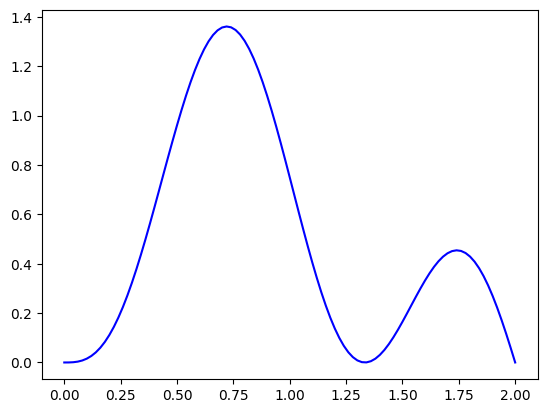

In [91]:
xGrid = Grid1(0,2, nPlot)
pdfX = tuple(dist.Pdf(x) for x in xGrid)

plot.plot(xGrid,pdfX, c='blue')

In [92]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 97


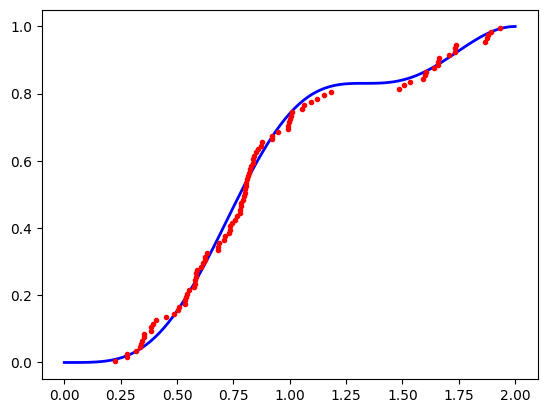

In [93]:
plot.plot(samp,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Change of Variable

In [94]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [95]:
map_.forSym

log(x/(2 - x))

In [96]:
sampZ = tuple(map_.Forward(x) for x in samp)

In [97]:
zMin,zMax = MinMax(sampZ)
zMin,zMax

(-2.0623272727950357, 3.3912929034575967)

In [98]:
jacobZSym = map_.invSym.diff(zSym).simplify().factor()
JacobZ = lambdify(zSym, jacobZSym)
jacobZSym

2*exp(z)/(exp(z) + 1)**2

In [99]:
jacobXSym = map_.forSym.diff(xSym).simplify().factor()
JacobX = lambdify(xSym, jacobXSym)
jacobXSym

-2/(x*(x - 2))

## Maximize Log-Likelihood for Sinc Approx of P(z)

In [100]:
nSinc = 11
sincZ = Grid1(zMin,zMax, nSinc)
h = (zMax - zMin) / (nSinc - 1)

In [101]:
nSinc, h

(11, 0.5453620176252633)

In [102]:
sincVal = cp.Variable(nSinc)
sincVal

Variable((11,), var16344)

In [103]:
nullZSym = (1 / jacobXSym).subs(xSym, map_.invSym).factor()
nullZ = lambdify(zSym, nullZSym)
nullZSym

2*exp(z)/(exp(z) + 1)**2

Text(0, 0.5, 'Nullifyer')

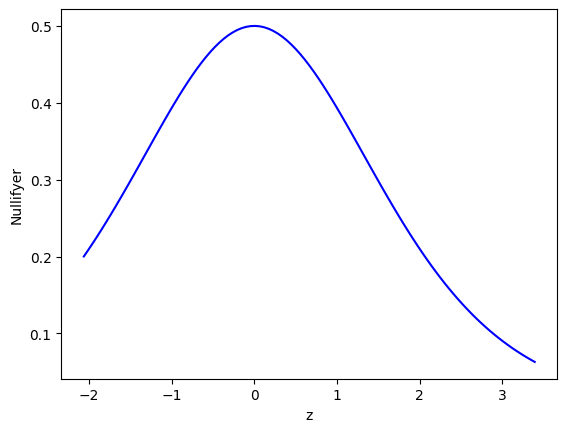

In [104]:
zGrid = Grid1(zMin,zMax, nPlot)
nullGrid = tuple(nullZ(z) for z in zGrid)

plot.plot(zGrid,nullGrid, c='blue')

plot.xlabel('z')
plot.ylabel('Nullifyer')

In [105]:
nullXSym = nullZSym.subs(zSym, map_.forSym).simplify()
nullX = lambdify(xSym, nullXSym)
nullXSym

x*(2 - x)/2

Text(0, 0.5, 'Nullifyer')

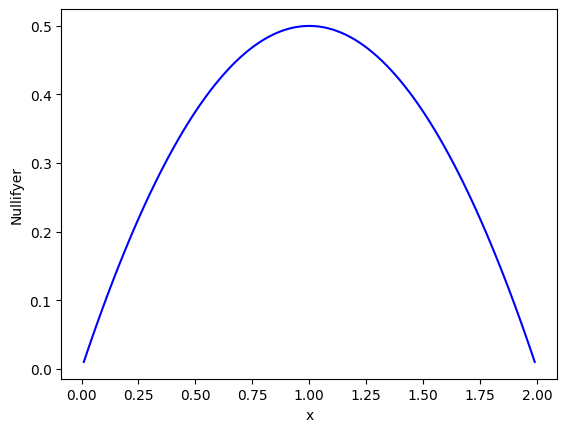

In [106]:
xGrid = tuple(2*(k + 0.5) / nPlot for k in range(nPlot))
nullGrid = tuple(nullX(x) for x in xGrid)

plot.plot(xGrid,nullGrid, c='blue')

plot.xlabel('x')
plot.ylabel('Nullifyer')

## Fit to Samples

In [144]:
logLikeP = lambda z: (
	cp.log(nullZ(z) * sum(sv * sinc((z - sz) / h) for (sz,sv) in zip(sincZ, sincVal))))
obj = cp.Maximize(sum(logLikeP(z) for z in sampZ))

TypeError: 'Mul' object is not callable

TODO:  Remove terms that depend only on z and not on the sinc values as they don't change the 
locaiton of the optimum but increase computation time.  But wait until this is documented.

### Total Area for Basis with Nullifyer

In [169]:
zKSym = Symbol('z_k')
hSym = Symbol('h')

In [170]:
sinc = sp.sin(sp.pi * zSym) / (sp.pi * zSym)
base = (sinc.subs(zSym, (zSym - zKSym) / hSym) * nullZSym).factor()
base

2*h*exp(z)*sin(pi*z/h - pi*z_k/h)/(pi*(z - z_k)*(exp(z) + 1)**2)

In [172]:
temp = sp.integrate(base * nullZSym, zSym)
temp

4*h*Integral(exp(2*z)*sin(pi*z/h - pi*z_k/h)/(z*exp(4*z) + 4*z*exp(3*z) + 6*z*exp(2*z) + 4*z*exp(z) + z - z_k*exp(4*z) - 4*z_k*exp(3*z) - 6*z_k*exp(2*z) - 4*z_k*exp(z) - z_k), z)/pi

In [162]:
area = temp.subs(zSym, sp.oo) - temp.subs(zSym, -sp.oo)
area

2*z_k

In [163]:
constEach = list(0 <= v for v in sincVal)
constArea = h * sum(v * area.subs(zKSym, zK) for (zK,v) in zip(sincZ, sincVal)) == 1

const = constEach + [constArea]

In [164]:
prob = cp.Problem(obj,const)

In [165]:
prob.solve()

3179.1057996083678

In [167]:
sincV = list(sincVal.value)
sincV

[268399787865764.75,
 221214825015435.2,
 195013311854051.0,
 171045996223287.47,
 163477126912596.12,
 54067691107439.33,
 141531668072054.72,
 154860688342923.1,
 42969350884897.32,
 91722314895864.89,
 86442556876479.69]

### Distribution Estimation on Z

Text(0, 0.5, 'PDF')

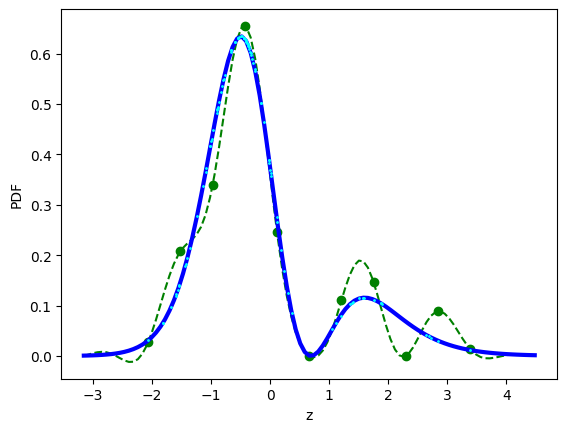

In [119]:
# True PDF of Z
zGrid = Grid1(zMin - 2*h, zMax + 2*h, nPlot)
pdf = tuple(dist.Pdf(map_.Inverse(z)) * JacobZ(z) for z in zGrid)
plot.plot(zGrid,pdf, c='blue', linewidth=3, zorder=1)

# The estiment of the PDF
sincVNull = tuple(v * nullZ(z) for (z,v) in zip(sincZ,sincV))
plot.plot(sincZ,sincVNull, 'o', c='green', zorder=0)

interpV = InterpZ(sincZ,sincV, zGrid)
interpNull = tuple(v * nullZ(z) for (z,v) in zip(zGrid,interpV))
plot.plot(zGrid,interpNull, '--', c='green', zorder=-1)

# show the samples
sampPdf = tuple(dist.Pdf(x) / JacobX(x) for x in samp)
plot.plot(sampZ,sampPdf, '.', c='cyan', markersize=2, zorder=2)

# sampEstPdf = InterpZ(sincZ,sincV, sampZ)
# plot.plot(sampZ,sampEstPdf, '.', c='brown')

plot.xlabel('z')
plot.ylabel('PDF')

### Distribution Estimate on X

In [120]:
sincX = tuple(map_.Inverse(z) for z in sincZ)

Text(0, 0.5, 'PDF')

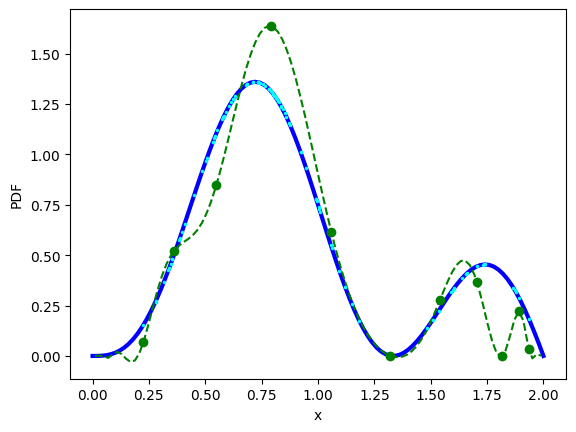

In [130]:
# show ture PDF in X
xGrid = Grid1(0,2, nPlot)
pdfX = tuple(dist.Pdf(x) for x in xGrid)
plot.plot(xGrid,pdfX, c='blue', linewidth=3)

# show the estiment of the PDF in X
pdfSincX = tuple(2.5 * v * nullX(x) for (x,v) in zip(sincX,sincV))
plot.plot(sincX,pdfSincX, 'o', c='green')

xGrid = tuple(2*(k + 0.5) / nPlot for k in range(nPlot))
zGrid = tuple(map_.Forward(x) for x in xGrid)
interpV = InterpZ(sincZ,sincV, zGrid)
interpNull = tuple(2.5 * v * nullX(x) for (x,v) in zip(xGrid,interpV))
plot.plot(xGrid,interpNull, '--', c='green')

# show samples
sampPdf = tuple(dist.Pdf(x) for x in samp)
plot.plot(samp,sampPdf, '.', c='cyan', markersize=3)

# sampEstPdf = InterpZ(sincZ,sincV, sampZ)
# plot.plot(sampZ,sampEstPdf, '.', c='brown')

plot.xlabel('x')
plot.ylabel('PDF')

## Think about total area constraint

In [139]:
sinc = sp.sin(sp.pi * zSym) / (sp.pi * zSym)

In [140]:
zKSym = Symbol('z_k')
sinc.subs(zSym, zSym - zKSym)

sin(pi*(z - z_k))/(pi*(z - z_k))

In [141]:
nullZSym

2*exp(z)/(exp(z) + 1)**2

In [143]:
sp.integrate(zKSym * nullZSym, zSym)

-2*z_k/(exp(z) + 1)